In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset,DataLoader,TensorDataset
import torchvision
from torchvision.transforms import transforms
from torchvision import models
import matplotlib.pyplot as plt

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import numpy as np
import pandas as pd


file_id = "1WZLFr195SGw2_UCzis-Djuov8c4HJPk1"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CXR_label.csv')

file_id = "1EixCdXLWw-tOh1ONlbIcQVTdw865c3sn"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CXR_image.npz')

file_id = "1RYZe6fiviC1ReJZb4H5B6nVb2-vUoEx7"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CT_label.csv')

file_id = "1WE6ntEDaXWAGMiphJqwG6uKGr-HxkV6Y"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CT_image.npz')

CXR_label = pd.read_csv('CXR_label.csv')
CXR_data = np.load(file='CXR_image.npz')
CXR_data_3d = CXR_data['arr']

CT_label = pd.read_csv('CT_label.csv')
CT_data = np.load(file='CT_image.npz')
CT_data_3d = CT_data['arr']

file_id = "1G-2JRcJRAzEcYudSB90bGBe3RJpDqm-m"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('CXRimg.npz')

CXRimg = np.load(file='CXRimg.npz')
china_cxr_normal = CXRimg['arr1']
iran_cxr_normal = CXRimg['arr2']
iran_cxr_covid19 = CXRimg['arr3']

Split data set

In [3]:
CT_cov = CT_label[CT_label['finding']=='COVID-19']
CT_nor = CT_label[CT_label['finding']=='Normal']

CXR_cov = CXR_label[CXR_label['finding']=='COVID-19']
CXR_nor = CXR_label[CXR_label['finding']=='Normal']

In [4]:
CT_China_cov = CT_cov[CT_cov['country'] == 'China']
CT_China_nor = CT_nor[CT_nor['country'] == 'China']


CT_Iran_cov = CT_cov[CT_cov['country'] == 'Iran']
CT_Iran_nor = CT_nor[CT_nor['country'] == 'Iran']

CXR_China_cov = CXR_cov[CXR_cov['location'] == 'China']

China data

In [5]:
China_CXR = []
China_CT = []
China_label = []


for i in range(240):

  CTimg = CT_data_3d[CT_China_cov.index[i]]
  CXRimg = CXR_data_3d[CXR_China_cov.index[i%24]]

  China_CT.append(CTimg)
  China_CXR.append(CXRimg)
  China_label.append(1)

for i in range(218):

  CTimg = CT_data_3d[CT_China_nor.index[i]]
  CXRimg = china_cxr_normal[i]

  China_CT.append(CTimg)
  China_CXR.append(CXRimg)
  China_label.append(0)

China_CT = np.array(China_CT)
China_CXR = np.array(China_CXR)
China_label = np.array(China_label)

Iran data

In [6]:
Iran_CXR = []
Iran_CT = []
Iran_label = []

for i in range(105):
  CTimg = CT_data_3d[CT_Iran_cov.index[i%35]]
  CXRimg = iran_cxr_covid19[i]

  Iran_CT.append(CTimg)
  Iran_CXR.append(CXRimg)
  Iran_label.append(1)

for i in range(230):
  CTimg = CT_data_3d[CT_Iran_nor.index[i]]
  CXRimg = iran_cxr_normal[i]

  Iran_CT.append(CTimg)
  Iran_CXR.append(CXRimg)
  Iran_label.append(0)

Iran_CXR = np.array(Iran_CXR)
Iran_CT = np.array(Iran_CT)
Iran_label = np.array(Iran_label)

In [11]:
#from google.colab import drive
#drive.mount('/content/drive')

#np.savez('/content/drive/MyDrive/DATA5703/data/iran and china dataset/Two_country_data.',
#         arr1=China_CT,arr2=China_CXR,arr3=China_label,arr4=Iran_CT,arr5=Iran_CXR,arr6=Iran_label)

In [ ]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
# feature extraction
def feature_extraction_vgg(data,model):

  inputs_ls = []
  outputs_ls = []
  for dat in data:
    inputs = data_transforms(dat)
    inputs_ls.append(inputs)
  del model.classifier
  model.classifier=lambda x:x

  for inputs in inputs_ls:
    inputs = torch.unsqueeze(inputs, dim=0)
    with torch.no_grad():
        inputs = inputs.to(device)
        outputs = model(inputs)
        outputs = torch.flatten(outputs[-1],0)
        outputs_ls.append(outputs)


  return outputs_ls

In [ ]:
# feature fuison
def fuse_data_VGG(CT_data,CXR_data,model,w =0.5):
  # CT
  CT_features = feature_extraction_vgg(CT_data, model)

  # CXR
  CXR_features = feature_extraction_vgg(CXR_data, model)
  output = []

  for i, (x,y) in enumerate(zip(CXR_features,CT_features)):
        CXR_fuse = x*w
        CT_fuse = y*(1-w)
        _fused_data = CXR_fuse + CT_fuse
        output.append(_fused_data)

  out = torch.stack(output,0)

  return out

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:{}'.format(device.type))

vgg = models.vgg19(pretrained=True)
VGG = vgg.to(device)

device:cuda


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
fused_China_feature = fuse_data_VGG(China_CT,China_CXR,VGG)
fused_Iran_feature = fuse_data_VGG(Iran_CT,Iran_CXR,VGG)

In [ ]:
y_China = torch.from_numpy(China_label)
y_Iran = torch.from_numpy(Iran_label)

x_China = fused_China_feature.float()
x_Iran = fused_Iran_feature.float()
y_China = y_China.long()
y_Iran = y_Iran.long()

China_dataset=TensorDataset(x_China,y_China)
Iran_dataset=TensorDataset(x_Iran,y_Iran)

In [ ]:
train_dataloader = DataLoader(dataset=China_dataset,batch_size=64, shuffle=True)
val_dataloader = DataLoader(dataset=Iran_dataset,batch_size=64, shuffle=True)

In [ ]:
classifier = models.vgg19(pretrained=True)
del classifier.features
classifier.features = lambda x:x
del classifier.avgpool
classifier.avgpool = lambda x:x
classifier.classifier._modules['6'] = nn.Sequential(nn.Linear(4096, 2), nn.Softmax(dim=1))

model = classifier.to(device)

loss_fc = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.5)  # step_size

In [ ]:
for epoch in range(100):

    running_loss = 0.0
    
    for i, sample_batch in enumerate(val_dataloader):
        inputs = sample_batch[0]
        labels = sample_batch[1]

        model.train()

        # GPU/CPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # foward
        outputs = model(inputs)

        # loss
        loss = loss_fc(outputs, labels)

        loss.backward()

        optimizer.step()

        #
        running_loss += loss.item()
    

        if epoch % 20 == 19:
            correct = 0
            total = 0
            model.eval()
            for images_test, labels_test in val_dataloader:
                images_test = images_test.to(device)
                labels_test = labels_test.to(device)

                outputs_test = model(images_test)
                _, prediction = torch.max(outputs_test, 1)
                correct += (torch.sum((prediction == labels_test))).item()
               # print(prediction, labels_test, correct)
                total += labels_test.size(0)
            print('[{}] running_loss = {:.5f}  train accurcay = {:.5f}'.format(epoch + 1, running_loss / 20,
                                                                        correct / total))
            running_loss = 0.0
    exp_lr_scheduler.step()
print('training finish !')

[20] running_loss = 0.01570  train accurcay = 1.00000
[20] running_loss = 0.01570  train accurcay = 1.00000
[20] running_loss = 0.01580  train accurcay = 1.00000
[20] running_loss = 0.01582  train accurcay = 1.00000
[20] running_loss = 0.01570  train accurcay = 1.00000
[20] running_loss = 0.01567  train accurcay = 1.00000
[40] running_loss = 0.01590  train accurcay = 1.00000
[40] running_loss = 0.01568  train accurcay = 1.00000
[40] running_loss = 0.01570  train accurcay = 1.00000
[40] running_loss = 0.01581  train accurcay = 1.00000
[40] running_loss = 0.01570  train accurcay = 1.00000
[40] running_loss = 0.01566  train accurcay = 1.00000
[60] running_loss = 0.01569  train accurcay = 1.00000
[60] running_loss = 0.01576  train accurcay = 1.00000
[60] running_loss = 0.01573  train accurcay = 1.00000
[60] running_loss = 0.01579  train accurcay = 1.00000
[60] running_loss = 0.01569  train accurcay = 1.00000
[60] running_loss = 0.01567  train accurcay = 1.00000
[80] running_loss = 0.01577 

classification report: 
              precision    recall  f1-score   support

      Normal       0.64      0.41      0.50       218
    COVID-19       0.60      0.79      0.68       240

    accuracy                           0.61       458
   macro avg       0.62      0.60      0.59       458
weighted avg       0.62      0.61      0.59       458


confusion matrix: 


Text(30.5, 0.5, 'true')

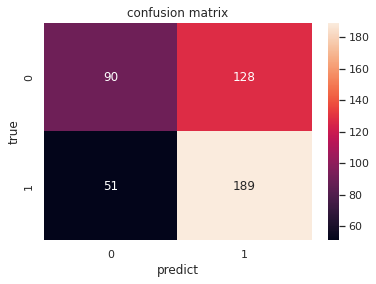

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
x_China = x_China.to(device)
outputs = model(x_China)
_, prediction = torch.max(outputs, 1)

print('classification report: ')
print(classification_report(y_China,prediction.cpu(),target_names=['Normal','COVID-19']))
print('')

CM = confusion_matrix(y_China,prediction.cpu())
sns.set()
f,ax=plt.subplots()
print('confusion matrix: ')
sns.heatmap(CM,annot=True,ax=ax,fmt='.20g') 
ax.set_title('confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true') 

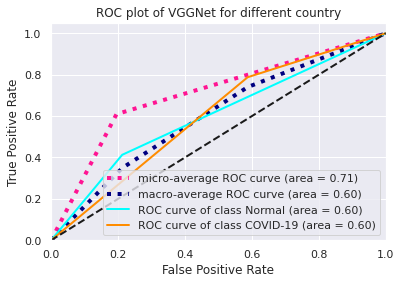

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import itertools 

def get_roc_auc(trues, preds):
  labels = [0,1]
  nb_classes = len(labels)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  #print(trues, preds)

  for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(trues[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(trues.ravel(), preds.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))
  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)

  for i in range(nb_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
  # Finally average it and compute AUC
  mean_tpr /= nb_classes
  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
  # Plot all ROC curves
  lw = 2
  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),color='deeppink', linestyle=':', linewidth=4)
  plt.plot(fpr["macro"], tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),color='navy', linestyle=':', linewidth=4)

  colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue'])
  label_name = ['Normal','COVID-19']

  for i, color in zip(range(nb_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(label_name[i], roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC plot of VGGNet for different country')
  plt.legend(loc="lower right")
  plt.show()

test_trues = label_binarize(y_China, classes=[i for i in range(3)])
test_preds = label_binarize(prediction.cpu(), classes=[i for i in range(3)])

get_roc_auc(test_trues, test_preds)


In [ ]:
#from google.colab import drive
#drive.mount('/content/MyDrive/')
#torch.save(model.state_dict(), '/content/MyDrive/MyDrive/DATA5703/code/model/VGGNet_different_country_model.pth')

#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

#file_id = "1har7RVyfleEZN888bUJVVUDC0xjtHqWs"
#downloaded = drive.CreateFile({'id': file_id})
#downloaded.GetContentFile('VGGNet_different_country_model.pth')

#classifier = models.vgg19(pretrained=False)
#del classifier.features
#classifier.features = lambda x:x
#del classifier.avgpool
#classifier.avgpool = lambda x:x
#classifier.classifier._modules['6'] = nn.Sequential(nn.Linear(4096, 3), nn.Softmax(dim=1))
#classifier.load_state_dict(torch.load('VGGNet_different_country_model.pth'))

#model = classifier.to(device)


Mounted at /content/MyDrive/


In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive/')
torch.save(model.state_dict(), '/content/MyDrive/MyDrive/DATA5703/code/model/VGGNet_different_country_model2.pth')

#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

#file_id = "112OZ8K3jtNW0FxIQO2ICtj_ABMI7j9X7"
#downloaded = drive.CreateFile({'id': file_id})
#downloaded.GetContentFile('VGGNet_different_country_model2.pth')

#classifier = models.vgg19(pretrained=False)
#del classifier.features
#classifier.features = lambda x:x
#del classifier.avgpool
#classifier.avgpool = lambda x:x
#classifier.classifier._modules['6'] = nn.Sequential(nn.Linear(4096, 3), nn.Softmax(dim=1))
#classifier.load_state_dict(torch.load('VGGNet_different_country_model2.pth'))

#model = classifier.to(device)

Mounted at /content/MyDrive/
